In [2]:
import os
import re
import csv
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import numpy as np

In [3]:
base_directory = "."

pattern = r"Average Precision\s+\(AP\)\s+@\[\s+IoU=0\.50:0\.95\s+\|\s+area=\s+all\s+\|\s+maxDets=100\s+\]\s+=\s+([0-9.]+)"

In [4]:
results = []

for root, _, files in os.walk(base_directory):
    for filename in files:
        if filename.endswith(".txt"):
            filepath = os.path.join(root, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()
                match = re.search(pattern, content)
                if match:
                    value = match.group(1)
                    filepath = filepath.split("/")[-1]
                    results.append([filepath, value])

In [5]:
output_file = "accuracy_list.csv"
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    # writer.writerow(["file_neme", "mAP"])
    writer.writerows(results)

output_file

'accuracy_list.csv'

In [6]:
def nested_dict():
    return defaultdict(nested_dict)

data = nested_dict()

with open('accuracy_list.csv', 'r') as file:
    reader = csv.reader(file)

    for row in reader:
        file_name, mAP = row
        mAP = float(mAP)

        parts = file_name.split('_')
        model = parts[0][4:6]
        # if model == 'v5' and parts[0][8] == '6':
        if model == 'v5' and len(parts[0]) > 7 and parts[0][7] == '6':
            print(parts)
            model = 'v5_6'

        if model == 'v1':
            model = 'v10'
            size = parts[0][7]
        elif model == 'v3':
            size = parts[0][7:]
            if size == '':
                size = 'normal'
        else:
            size = parts[0][6]
        dtype = parts[1][0:-4]

        data[model][size][dtype] = mAP

dtype_order = ['float32', 'float16', 'int8']

for model, sizes in data.items():
    for size, dtypes in sizes.items():
        # dtypesの中で存在するものだけを順番に並べる
        ordered_dtypes = OrderedDict(
            (dtype, dtypes[dtype]) for dtype in dtype_order if dtype in dtypes
        )
        data[model][size] = ordered_dtypes  # 並び替えた結果で上書き


default_model_size_order = ['n', 's', 'm', 'l', 'x']
v3_model_size_order = ['tiny', 'normal', 'spp']
v9_model_size_order = ['t', 's', 'm', 'c', 'e']
v10_model_size_order = ['n', 's', 'm', 'b', 'l', 'x']


for model, sizes in data.items():
    if model == 'v3':
        model_size_order = v3_model_size_order
    elif model == 'v9':
        model_size_order = v9_model_size_order
    elif model == 'v10':
        model_size_order = v10_model_size_order
    else:
        model_size_order = default_model_size_order
    ordered_sizes = OrderedDict((size, sizes[size]) for size in model_size_order if size in sizes)
    data[model] = ordered_sizes

model_order = ['v3', 'v5', 'v5_6', 'v8', 'v9', 'v10', '11']

data = OrderedDict((model, data[model]) for model in model_order if model in data)

['yolov5s6', 'float16.txt']
['yolov5s6', 'float32.txt']
['yolov5n6', 'float16.txt']
['yolov5n6', 'int8.txt']
['yolov5n6', 'float32.txt']


In [7]:
mygreen = "#548235"
myorange = "#D46112"
myblue = "#1378A5"
myred = "#C00000"
mypurple = "#6A2D97"
mygold = "#DAA600"

In [8]:
color_list = {"float32": myblue, "float16": myorange, "int8": mygreen}
fontsize = 18
legend_fontsize = 14

4


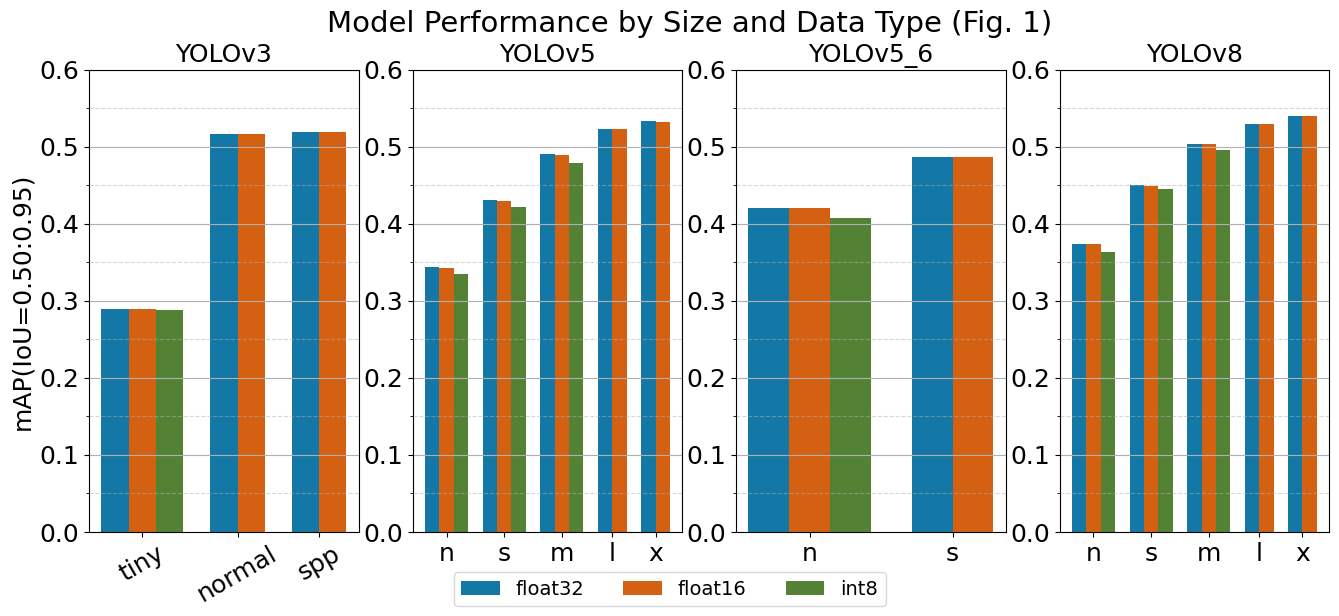

3


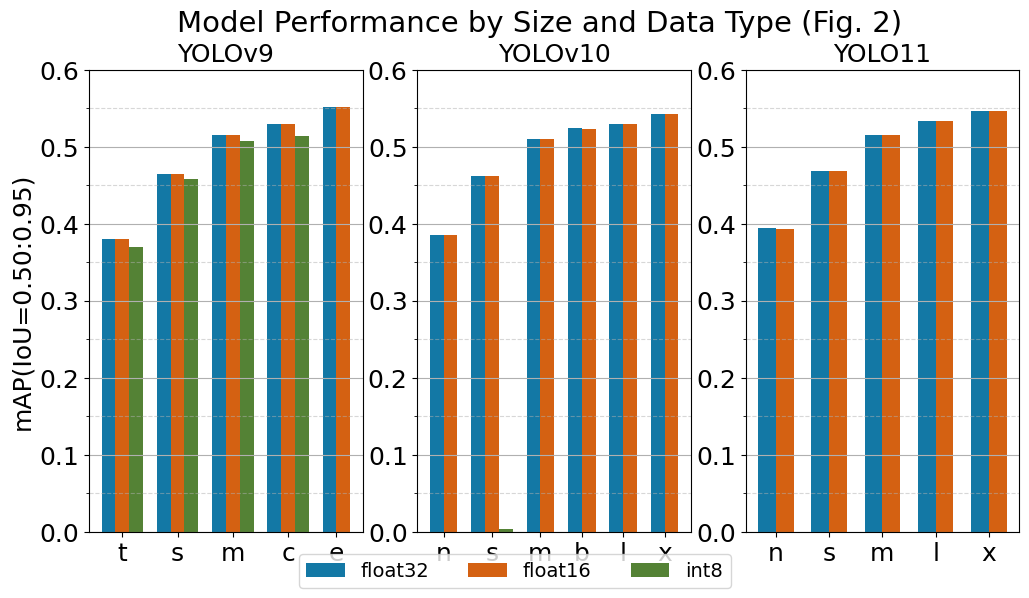

In [9]:
# モデル数とモデル名のリストを取得
model_count = len(data)
model_list = list(data.keys())

# 1つの図に表示する最大モデル数
max_models_per_fig = 4
num_figs = (model_count + max_models_per_fig - 1) // max_models_per_fig

width = 0.1

for fig_num in range(num_figs):
    # この図に含まれるモデルの範囲を決定
    start_index = fig_num * max_models_per_fig
    end_index = min((fig_num + 1) * max_models_per_fig, model_count)

    plot_len = end_index - start_index
    print(plot_len)

    fig, ax = plt.subplots(1, plot_len, figsize=(plot_len * 4, 6))
    
    if end_index - start_index == 1:
        ax = [ax]  # 1つだけの場合でもリストに変換する

    for i, model in enumerate(model_list[start_index:end_index]):
        plot_start = 0
        x_ticks = []
        size_list = []
        
        for j, size in enumerate(data[model]):
            size_list.append(size)
            value_count = len(data[model][size])
            for k, dtype in enumerate(data[model][size]):
                value = data[model][size][dtype]
                if i == 0 and j == 0:
                    ax[i].bar(plot_start + k * width, value, width=width, color=color_list[dtype], label=dtype)
                else:
                    ax[i].bar(plot_start + k * width, value, width=width, color=color_list[dtype])

            x_ticks.append(plot_start + ((value_count - 1) * width) / 2)
            plot_start += (value_count + 1) * width

        ax[i].set_xticks(x_ticks, size_list, size=fontsize)
        ax[i].set_title(f"YOLO{model}", size=fontsize)
        ax[i].tick_params(labelsize=fontsize)
        ax[i].yaxis.grid(True)
        ax[i].set_ylim(0, 0.6)

        yticks_minor = np.arange(0, 0.65, 0.05)
        ax[i].set_yticks(yticks_minor, minor=True)
        ax[i].grid(True, which='minor', linestyle='--', alpha=0.5)

        if model == 'v3':
            ax[i].tick_params(axis='x', rotation=30)

    ax[0].set_ylabel("mAP(IoU=0.50:0.95)", size=fontsize)
    fig.legend(loc='lower center', ncol=3, fontsize=legend_fontsize)
    # fig.suptitle(f"Model Performance by Size and Data Type (Fig {fig_num + 1})", size=fontsize + 5)

    if num_figs > 1:
        fig.suptitle(f"Model Performance by Size and Data Type (Fig. {fig_num + 1})", size=fontsize + 3)
    else:
        fig.suptitle("Model Performance by Size and Data Type", size=fontsize + 3)        

    plt.show()